# BENO-Investigation

# Training

In [6]:
import os
os.getcwd()

'/content/beno'

In [ ]:
!git clone https://anonymous.4open.science/r/beno-F36F.git


In [8]:
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1

In [9]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)


PyTorch version: 2.5.1+cu124
CUDA version: 12.4


In [10]:
# For PyTorch 2.5.1 + CUDA 12.4
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric
!pip install loguru


Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


In [11]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint as pp
from timeit import default_timer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import scatter  # Not included in the latest version
from torchvision.transforms import GaussianBlur
import sys, os
# from utilities import *
from utilities import MeshGenerator,GaussianNormalizer,LpLoss
from util import record_data, to_cpu, to_np_array, make_dir
from BE_MPNN import HeteroGNS
from BE_MPNN_GPS import HeteroGNSGPS
import random
from loguru import logger
import matplotlib.tri as tri
from torch_geometric.data import HeteroData
from data_setup import make_graph
import warnings
warnings.filterwarnings('ignore')
import pdb
fix_seed = 2023
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## 1. Set training arguments

In [12]:
class Args:
    epochs = 1000
    lr = 0.00005
    inspect_interval = 100
    id = "0"
    init_boudary_loc = "regular"
    boundary_encoding = "GPS"
    trans_layer = 3
    boundary_dim = 128
    batch_size = 1
    act = "silu"
    nmlp_layers = 3
    ns = 100
    n_heads = 4
    bd_shape = "4c"

args = Args()


## 2. Load Data

We aim to solve a $d$-dimensional-differntiable function $u \in C^d(\mathbb R)$ of $N$ interior grid nodes over an open domain $\Omega$. This paper primarily works with Poisson equation with Dirichlet boundar conditions. E.g. for $d = 2$ the data is
$$ \nabla^2 u ([x_1, x_2, \dots, x_d)]) = f([x_1, x_2, \dots, x_d]), \quad \forall ([x_1, \dots, x_d]) \in \Omega$$
$$ u ([x_1, x_2, \dots, x_d)]) = g([x_1, x_2, \dots, x_d]), \quad \forall ([x_1, \dots, x_d]) \in \partial \Omega.$$

Here we load a sample of 10 4-corner dataset

In [13]:
# Extrat zip files
import zipfile
with zipfile.ZipFile('/content/beno/data/Dirichlet/Dirichlet_N32_data_10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/beno/data/Dirichlet/10')

with zipfile.ZipFile('/content/beno/data/Dirichlet/Dirichlet_N32_data_100.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/beno/data/Dirichlet/100')
with zipfile.ZipFile('/content/beno/data/Neumann/Neumann_N32_data_100.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/beno/data/Neumann/100')


In [14]:
f_alls = {}
sol_alls = {}
bc_alls = {}



In [15]:
# Load datasets
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, "data")
shapes = ["4c", "3c", "2c", "1c", "0c", "mix"]
for shape in shapes:
    f_alls[shape] = np.load("/content/beno/data/Dirichlet/100/RHS_N32_" + shape + "_100.npy") # the source function
    sol_alls[shape] = np.load("/content/beno/data/Dirichlet/100/SOL_N32_" + shape + "_100.npy") # the solution
    bc_alls[shape] =np.load("/content/beno/data/Dirichlet/100/BC_N32_" + shape + "_100.npy") # the boundary condition
ntrain = 90
ntest =10

In [16]:
gblur = GaussianBlur(kernel_size=5, sigma=5)


batch_size = args.batch_size
batch_size2 = args.batch_size
width = 64
ker_width = 256
depth = 4
edge_features = 7
node_features = 10
ns=args.ns
epochs = args.epochs
learning_rate = args.lr
inspect_interval = args.inspect_interval

runtime = np.zeros(2, )
t1 = default_timer()

resolution = 32
s = resolution
n=s**2


trans_layer = args.trans_layer

path = 'Resolution_' + str(s) + '_poisson' + \
    '_ntrain'+str(ntrain)+'_kerwidth'+str(ker_width) + '_bd_enc_' + args.boundary_encoding + str(args.trans_layer) +\
    '_Rolling' + args.init_boudary_loc+  '_shape' + args.bd_shape +'_ns'+str(args.ns)+\
    '_nheads'+str(args.n_heads)+'_bddim'+str(args.boundary_dim)+"_act"+args.act+'lr'+str(args.lr)+'_nmlp_layers'+str(args.nmlp_layers)+'_epochs' + str(args.epochs)

result_path = os.path.join(cwd, "results")
path_model = os.path.join(result_path,path )
make_dir(path_model)

logger.add(os.path.join('log', '{}.log'.format(
            path)), rotation="500 MB", level="INFO")
logger.info(path)


2025-04-07 10:44:22.737 | INFO     | __main__:<cell line: 0>:37 - Resolution_32_poisson_ntrain90_kerwidth256_bd_enc_GPS3_Rollingregular_shape4c_ns100_nheads4_bddim128_actsilulr5e-05_nmlp_layers3_epochs1000


directory /content/beno/results does not exist, created.


In [18]:
datasets_train = {}
datasets_test = {}
coord_alls = {}
u_normalizers = {}
for shape in shapes:
    datasets_train[shape], datasets_test[shape], coord_alls[shape], u_normalizers[shape] = make_graph(f_alls[shape], bc_alls[shape], sol_alls[shape], resolution, ntrain, ntest)

data_train = datasets_train[args.bd_shape]
data_test = datasets_test[args.bd_shape]
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size2, shuffle=False)
t2 = default_timer()

print("Dataset created")
print(f"{len(data_train)} training data")
print(f" Training data examples: {data_train[0]}")
print(f"{len(data_test)} testing data")
print(f" Testing data examples: {data_test[0]}")

Dataset created
90 training data
 Training data examples: HeteroData(
  G1={
    x=[965, 10],
    boundary=[128, 3],
    edge_features=[11689, 7],
    sample_idx=[965],
    edge_index=[2, 11689],
    bd_edge_index=[2, 598],
    bd_edge_features=[598, 7],
  },
  G2={
    x=[965, 10],
    boundary=[128, 3],
    edge_features=[11689, 7],
    sample_idx=[965],
    edge_index=[2, 11689],
    bd_edge_index=[2, 598],
    bd_edge_features=[598, 7],
  },
  G1+2={ y=[965] }
)
10 testing data
 Testing data examples: HeteroData(
  G1={
    x=[948, 10],
    boundary=[128, 3],
    edge_features=[11528, 7],
    sample_idx=[948],
    edge_index=[2, 11528],
    bd_edge_index=[2, 590],
    bd_edge_features=[590, 7],
  },
  G2={
    x=[948, 10],
    boundary=[128, 3],
    edge_features=[11528, 7],
    sample_idx=[948],
    edge_index=[2, 11528],
    bd_edge_index=[2, 590],
    bd_edge_features=[590, 7],
  },
  G1+2={ y=[948] }
)


Now check the shape for train and test dataset

### Visualized the dataset as examples

What each component represent
1. G1: the graph that solves $\Delta u = f$ with zero boundary.
    - x = [num\_nodes, num\_node\_features]: features include coordinates, a(x, y), smoothed a, gradients, distance to boundary

    - boundary = [num\_boundary\_nodes, 3] : number of nodes that are on the boundaries, 3 values are x y coordinates and boundar value which is 0

    - edge\_features = [num\_edges, num\_edge\_features]: features are [x1,y1, x2, y2, theta1, theta2, distance]

    - sample\_indx = [num\_nodes]:  Indices of the mesh points being used
    - edge_index = [2, num\_edges]:  Connectivity matrix: 2 rows (source,target), 6733 edges
    - bd_edge_index = [2, num_edges_on_boundary]: connectivity matrix of 2 rows on the boudnary
    - bd_edge_features = [num\_edges\_on\_boundary, num\_edge\_features\_on\_ boundaries]: features are [x1,y1, x2, y2, 0, 0, distance]

2.  G2: that graph solves $\Delta u = 0$ with given boundary condition $g(x)$
    - x = [num\_nodes, num\_node\_features]: Same structure as G1 but different features, zero source term instead of f

    - boundary = [num\_boundary\_nodes, 3] : Boundary points with actual boundary values g(x)

    - edge\_features = [num\_edges, num\_edge\_features]: Same edge features as G1
    - sample\_indx = [num\_nodes]:  Same indices as G1
    - edge_index = [2, num\_edges]:  Same connectivity as G1

3. G1+2: Combined solution target
    - y = [num\_target\_nodes]: values of solution at the target nodes
)


# 5. Load Data and Models

In [24]:


logger.info('preprocessing finished, time used:{}', t2-t1)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if args.act == 'leakyrelu':
    activation = nn.LeakyReLU
elif args.act == 'elu':
    activation = nn.ELU
elif args.act == 'relu':
    activation = nn.ReLU
else:
    activation = nn.SiLU

if args.boundary_encoding == 'GPS':
    model = HeteroGNSGPS(nnode_in_features = node_features, nnode_out_features = 1, nedge_in_features = edge_features, nmlp_layers=args.nmlp_layers,
             activation = activation,boundary_dim = args.boundary_dim,trans_layer = trans_layer).to(device)
else:
    model = HeteroGNS(nnode_in_features = node_features, nnode_out_features = 1, nedge_in_features = edge_features, nmlp_layers=args.nmlp_layers,
             activation = activation,boundary_dim = args.boundary_dim,trans_layer = trans_layer).to(device)

u_normalizer = u_normalizers[args.bd_shape]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=16, T_mult=2)
myloss = LpLoss(size_average=False)
u_normalizer.cuda(device)
ttrain = np.zeros((epochs, ))
ttest = np.zeros((epochs,))
model.train()

data_record = {}

2025-04-07 10:56:35.433 | INFO     | __main__:<cell line: 0>:1 - preprocessing finished, time used:-280.1658485810003


In [25]:
model

HeteroGNSGPS(
  (_encoder): Encoder(
    (node_fn): Sequential(
      (0): Sequential(
        (NN-0): Linear(in_features=10, out_features=128, bias=True)
        (Act-0): SiLU()
        (NN-1): Linear(in_features=128, out_features=128, bias=True)
        (Act-1): SiLU()
        (NN-2): Linear(in_features=128, out_features=128, bias=True)
        (Act-2): SiLU()
        (NN-3): Linear(in_features=128, out_features=128, bias=True)
        (Act-3): Identity()
      )
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (edge_fn): Sequential(
      (0): Sequential(
        (NN-0): Linear(in_features=7, out_features=128, bias=True)
        (Act-0): SiLU()
        (NN-1): Linear(in_features=128, out_features=128, bias=True)
        (Act-1): SiLU()
        (NN-2): Linear(in_features=128, out_features=128, bias=True)
        (Act-2): SiLU()
        (NN-3): Linear(in_features=128, out_features=128, bias=True)
        (Act-3): Identity()
      )
      (1): LayerNorm((128,)

In [26]:
transformer = model._processor.gnn_stacks[0].boundary_fn
transformer

GPS(
  (node_emb): DataEmbedding_wo_temp(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(3, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 128)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 128)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 128)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 128)
      )
    )
    (dropout): Dropout(p=0, inplace=False)
  )
  (convs): ModuleList(
    (0-2): 3 x GPSConv(128, conv=GINEConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=128, bias=True)
    )), heads=4, attn_type=multihead)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128,

The transformer performs input embedding and passes the embedding into the encoder.

The procedure of embedding is as below

Conduct max pooling on the last dimension

### Now test this new transformer

# Train!

In [27]:
epochs = args.epochs

for ep in range(epochs):
    model.train() #改的
    t1 = default_timer()
    train_mse = 0.0
    train_l2 = 0.0
    for batch in train_loader:

        # n = np.random.randint(2)
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out.view(-1, 1), batch['G1+2'].y.view(-1,1))

        loss.backward()
        l2 = myloss(
            u_normalizer.decode(out.view(batch_size, -1), sample_idx=batch['G1'].sample_idx.view(batch_size, -1)),
            u_normalizer.decode(batch['G1+2'].y.view(batch_size, -1), sample_idx=batch['G1'].sample_idx.view(batch_size, -1))) #G1和G2的sanmple_idx是一样的

        # pdb.set_trace()
        optimizer.step()
        train_mse += loss.item()
        train_l2 += l2.item()

    scheduler.step()
    t2 = default_timer()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            out = u_normalizer.decode(out.view(batch_size2,-1), sample_idx=batch['G1'].sample_idx.view(batch_size2,-1))
            test_l2 += myloss(out, batch['G1+2'].y.view(batch_size2, -1)).item()

    t3 = default_timer()
    ttrain[ep] = train_l2/(ntrain)
    ttest[ep] = test_l2/ntest
    logger.info(f"Epoch {ep:03d}     train_Loss: {train_mse/len(train_loader):.6f}  \t train_L2: {train_l2/(ntrain):.6f}\t test_L2: {test_l2/ntest:.6f}")
    record_data(data_record, [ep, train_mse/len(train_loader), train_l2/(ntrain), test_l2/ntest], ["epoch", "train_MSE", "train_L2", "test_L2"])
    if ep % inspect_interval == 0 or ep == epochs - 1:
        record_data(data_record, [ep, to_cpu(model.state_dict())], ["save_epoch", "state_dict"])
        pickle.dump(data_record, open(path_model, "wb"))

2025-04-07 10:57:10.984 | INFO     | __main__:<cell line: 0>:41 - Epoch 000     train_Loss: 1.010418  	 train_L2: 1.005438	 test_L2: 1.002636
2025-04-07 10:57:40.699 | INFO     | __main__:<cell line: 0>:41 - Epoch 001     train_Loss: 0.967800  	 train_L2: 0.987889	 test_L2: 1.015229
2025-04-07 10:58:09.161 | INFO     | __main__:<cell line: 0>:41 - Epoch 002     train_Loss: 0.944863  	 train_L2: 0.982178	 test_L2: 0.986234
2025-04-07 10:58:38.510 | INFO     | __main__:<cell line: 0>:41 - Epoch 003     train_Loss: 0.845896  	 train_L2: 0.941283	 test_L2: 1.010692
2025-04-07 10:59:07.405 | INFO     | __main__:<cell line: 0>:41 - Epoch 004     train_Loss: 0.816167  	 train_L2: 0.928214	 test_L2: 1.056958
2025-04-07 10:59:37.071 | INFO     | __main__:<cell line: 0>:41 - Epoch 005     train_Loss: 0.793800  	 train_L2: 0.915228	 test_L2: 1.025665
2025-04-07 11:00:06.462 | INFO     | __main__:<cell line: 0>:41 - Epoch 006     train_Loss: 0.769183  	 train_L2: 0.899626	 test_L2: 1.041502
2025-0

In [ ]:
while True:
    pass

Download trained models on google drive and to local machine

In [30]:
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import shutil
from google.colab import files, drive

source_file_path = '/content/beno/results/Resolution_32_poisson_ntrain90_kerwidth256_bd_enc_GPS3_Rollingregular_shape4c_ns100_nheads4_bddim128_actsilulr5e-05_nmlp_layers3_epochs1000'  # Update this to your file's path

# Destination path in Google Drive
destination_path = '/content/drive/MyDrive/Resolution_32_poisson_ntrain90_kerwidth256_bd_enc_GPS3_Rollingregular_shape4c_ns100_nheads4_bddim128_actsilulr5e-05_nmlp_layers3_epochs1000'  # Update folder and filename

# Copy the file
shutil.copy(source_file_path, destination_path)

# Optional: Verify the file was copied successfully
import os
if os.path.exists(destination_path):
    print(f"File successfully saved to Google Drive at: {destination_path}")
    print(f"File size: {os.path.getsize(destination_path) / (1024 * 1024):.2f} MB")
else:
    print("File was not saved successfully.")


File successfully saved to Google Drive at: /content/drive/MyDrive/Resolution_32_poisson_ntrain90_kerwidth256_bd_enc_GPS3_Rollingregular_shape4c_ns100_nheads4_bddim128_actsilulr5e-05_nmlp_layers3_epochs1000
File size: 1156.20 MB


Save training loss separately

In [32]:
train_file = 'Resolution_' + str(s) + '_poisson' + \
    '_ntrain'+str(ntrain)+'_kerwidth'+str(ker_width) + '_bd_enc_' + args.boundary_encoding + str(args.trans_layer) +\
    '_Rolling' + args.init_boudary_loc+ '_shape' + args.bd_shape +'_ns'+str(args.ns)+\
    '_nheads'+str(args.n_heads)+'_bddim'+str(args.boundary_dim)+"_act"+args.act+'lr'+str(args.lr)+'_nmlp_layers'+str(args.nmlp_layers)+ '_train.npy'

test_file = 'Resolution_' + str(s) + '_poisson' + \
    '_ntrain'+str(ntrain)+'_kerwidth'+str(ker_width) + '_bd_enc_' + args.boundary_encoding + str(args.trans_layer) +\
    '_Rolling' + args.init_boudary_loc + '_shape' + args.bd_shape +'_ns'+str(args.ns)+\
    '_nheads'+str(args.n_heads)+'_bddim'+str(args.boundary_dim)+"_act"+args.act+'lr'+str(args.lr)+'_nmlp_layers'+str(args.nmlp_layers)+ '_test.npy'

result_path = os.path.join(cwd, "log")
train_path = os.path.join(result_path,train_file)
test_path = os.path.join(result_path, test_file)
np.save(train_path, ttrain)
np.save(test_path, ttest)

# Test

First load baseline BENO model from google drive

In [33]:
modelTransformer = HeteroGNS(nnode_in_features = node_features, nnode_out_features = 1, nedge_in_features = edge_features, nmlp_layers=args.nmlp_layers,
                activation = activation,boundary_dim = args.boundary_dim,trans_layer = trans_layer).to(device)
transformer_4c_filename_model = '/content/drive/MyDrive/Resolution_32_poisson_ntrain90_kerwidth256_bd_enc_transformer3_Rollingregular_shape4c_ns100_nheads4_bddim128_actsilulr5e-05_nmlp_layers3_epochs1000'
transformer_4c_data_record = pickle.load(open(f"{transformer_4c_filename_model}", "rb"))
modelTransformer.load_state_dict(transformer_4c_data_record["state_dict"][-1])

<All keys matched successfully>

## Plot Solution vs Prediction

In [37]:
model.eval()
train_mse = 0.0
train_l2 = 0.0
for i in range(len(data_train)):
    batch = data_train[i]

    # n = np.random.randint(2)
    batch = batch.to(device)
    optimizer.zero_grad()
    out = model(batch)
    loss = F.mse_loss(out.view(-1, 1), batch['G1+2'].y.view(-1,1))

    l2 = myloss(
        u_normalizer.decode(out.view(batch_size, -1), sample_idx=batch['G1'].sample_idx.view(batch_size, -1)),
        u_normalizer.decode(batch['G1+2'].y.view(batch_size, -1), sample_idx=batch['G1'].sample_idx.view(batch_size, -1))) #G1和G2的sanmple_idx是一样的

    # pdb.set_trace()
    train_mse += loss.item()
    train_l2 += l2.item()

print(f"Train mse = {train_mse / len(data_train)}")
print(f"Train l2 = {train_l2 / len(data_train)}")

Train mse = 0.007040229243122869
Train l2 = 0.08759648046559758


In [40]:
isinstance(model, HeteroGNSGPS)

True

In [95]:
def test_accr(data_train, data_test, u_normalizer, coord_all, shape, model):

    model.train()
    test_l2 = np.zeros(100)
    test_mse = np.zeros(100)

    with torch.no_grad():
        for i in range(len(data_train)):
            batch = data_train[i]
            batch = batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out.view(-1, 1), batch['G1+2'].y.view(-1,1))
            test_mse[i] = loss.item()
            out = u_normalizer.decode(out.view(batch_size2,-1), sample_idx=batch['G1'].sample_idx.view(batch_size2,-1))
            test_l2[i] = myloss(out, batch['G1+2'].y.view(batch_size2, -1)).item()

        for i in range(len(data_test)):

            batch = data_test[i]
            batch = batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out.view(-1, 1), batch['G1+2'].y.view(-1,1))
            test_mse[i + 90] = loss.item()
            out = u_normalizer.decode(out.view(batch_size2,-1), sample_idx=batch['G1'].sample_idx.view(batch_size2,-1))
            test_l2[i + 90] = myloss(out, batch['G1+2'].y.view(batch_size2, -1)).item()
    if isinstance(model, HeteroGNSGPS):

        print("BENO-GPS")
    else:
        print("BENO-Transformer")
    print(f"Shape: {shape}")
    print(f"Train MSE: {np.average(test_mse[:ntrain]):.6f} +- {np.std(test_mse[:ntrain]):.6f}")
    print(f"Test MSE: {np.average(test_mse[ntrain:]):.6f} +- {np.std(test_mse[ntrain:]):.6f}")
    print(f"Average MSE: {np.average(test_mse):.6f} +- {np.std(test_mse):.6f}")
    print(f"Train L2: {np.average(test_l2[:ntrain]):.6f} +- {np.std(test_l2[:ntrain]):.6f}")
    print(f"Test L2: {np.average(test_l2[ntrain:]):.6f} +- {np.std(test_l2[ntrain:]):.6f}")
    print(f"Average L2: {np.average(test_l2):.6f} +- {np.std(test_l2):.6f}")


In [94]:
a = np.arange(10)
a[:5]

array([0, 1, 2, 3, 4])

In [96]:
shape = args.bd_shape
test_accr(datasets_train[shape], datasets_test[shape],u_normalizers[shape], coord_alls[shape], shape, model)

BENO-GPS
Shape: 4c
Train MSE: 0.007040 +- 0.002583
Test MSE: 1.427635 +- 0.087546
Average MSE: 0.149100 +- 0.427084
Train L2: 0.995527 +- 0.000038
Test L2: 1.532397 +- 0.316701
Average L2: 1.049214 +- 0.189659


In [97]:
shape = args.bd_shape
test_accr(datasets_train[shape], datasets_test[shape],u_normalizers[shape], coord_alls[shape], shape, modelTransformer)

BENO-Transformer
Shape: 4c
Train MSE: 0.012866 +- 0.005427
Test MSE: 1.175336 +- 0.223565
Average MSE: 0.129113 +- 0.355872
Train L2: 0.995561 +- 0.000054
Test L2: 1.455305 +- 0.305867
Average L2: 1.041535 +- 0.168459


In [49]:
for shape in shapes:
    test_accr(datasets_train[shape], datasets_test[shape],u_normalizers[shape], coord_alls[shape], shape, model)


BENO-GPS
Shape: 4c
Test MSE: 0.149100 +- 0.427084
Test L2: 1.049214 +- 0.189659
BENO-GPS
Shape: 3c
Test MSE: 0.431173 +- 0.299210
Test L2: 1.036623 +- 0.142341
BENO-GPS
Shape: 2c
Test MSE: 0.483940 +- 0.283265
Test L2: 1.043320 +- 0.156840
BENO-GPS
Shape: 1c
Test MSE: 0.588235 +- 0.360109
Test L2: 1.037798 +- 0.150868
BENO-GPS
Shape: 0c
Test MSE: 0.585513 +- 0.379586
Test L2: 1.042139 +- 0.146388
BENO-GPS
Shape: mix
Test MSE: 0.476420 +- 0.301533
Test L2: 1.026338 +- 0.130338


In [48]:
for shape in shapes:
    test_accr(datasets_train[shape], datasets_test[shape],u_normalizers[shape], coord_alls[shape], shape, modelTransformer)

BENO-Transformer
Shape: 4c
Test MSE: 0.129113 +- 0.355872
Test L2: 1.041535 +- 0.168459
BENO-Transformer
Shape: 3c
Test MSE: 0.641800 +- 0.309088
Test L2: 1.049483 +- 0.168607
BENO-Transformer
Shape: 2c
Test MSE: 0.639115 +- 0.381611
Test L2: 1.010004 +- 0.055058
BENO-Transformer
Shape: 1c
Test MSE: 0.747246 +- 0.342523
Test L2: 1.014358 +- 0.077861
BENO-Transformer
Shape: 0c
Test MSE: 0.841007 +- 0.401048
Test L2: 1.061227 +- 0.199349
BENO-Transformer
Shape: mix
Test MSE: 0.637934 +- 0.301172
Test L2: 1.035743 +- 0.154675


In [84]:
def plot_prediction(data_train, coord_all, i, args):
    batch = data_train[i]

    with torch.no_grad():
        out_gps = model(batch.to(device))
        out_transformer = modelTransformer(batch.to(device))
    # Plot an example
    #out = u_normalizer.decode(out.view(batch_size2,-1), sample_idx=batch['G1'].sample_idx.view(batch_size2,-1))
    plot_file = args.bd_shape + '_trained_'  + shape + "_test_" + ".png"

    plots_path = os.path.join(cwd, "plots")
    plot_path = os.path.join(plots_path, plot_file)

    num_points = len(coord_all[i, :, :])
    length = int(np.sqrt(num_points))
    idx = batch['G1'].sample_idx.cpu().detach().numpy()

    x_mesh = coord_all[i,:, 0].reshape(32, 32)
    y_mesh = coord_all[i,:, 1].reshape(32, 32)
    y_true = np.zeros(num_points)
    y_pred_gps = np.zeros(num_points)
    y_pred_transformer = np.zeros(num_points)

    y = batch['G1+2'].y.detach().to('cpu')
    y_true[np.array(idx)] = y.numpy()  # No need to detach or move to CPU again
    y_pred_gps[np.array(idx)] = out_gps.squeeze().detach().cpu().numpy()
    y_pred_transformer[np.array(idx)] = out_transformer.squeeze().detach().cpu().numpy()


    mask = np.zeros((len(coord_all[i, :, :])), dtype=bool)
    mask[idx] = True
    y_true_masked = np.ma.masked_where(~mask, y_true)
    y_pred_gps_masked = np.ma.masked_where(~mask, y_pred_gps)
    y_pred_transformer_masked = np.ma.masked_where(~mask, y_pred_transformer)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)


    pcm = ax1.pcolormesh(x_mesh, y_mesh, y_true_masked.reshape(32, 32), shading='auto', cmap="viridis", vmin=-4, vmax=4)

    ax1.set_title("Groundtruth Solution")

    pcm = ax2.pcolormesh(x_mesh, y_mesh, y_pred_transformer_masked.reshape(32, 32), shading='auto', cmap="viridis", vmin=-4, vmax=4)

    ax2.set_title("Predicted Solution (Transformer)")

    pcm = ax3.pcolormesh(x_mesh, y_mesh, y_pred_gps_masked.reshape(32, 32), shading='auto', cmap="viridis", vmin=-4, vmax=4)
    fig.colorbar(pcm, ax=ax3)

    ax3.set_title("Predicted Solution (GPS)")

    #absmax = np.max(np.hstack((y_pred_transformer_masked - y_true_masked), np.abs(y_pred_gps_masked - y_true_masked)))
    pcm = ax4.pcolormesh(x_mesh, y_mesh, (y_pred_transformer_masked - y_true_masked).reshape(32, 32), shading='auto', cmap="PiYG", vmin=-2.5, vmax=2.5)

    ax4.set_title("Error (Transformer)")

    pcm = ax5.pcolormesh(x_mesh, y_mesh, (y_pred_gps_masked - y_true_masked).reshape(32, 32), shading='auto', cmap="PiYG", vmin=-2.5, vmax=2.5)


    ax5.set_title("Error (GPS)")
    fig.colorbar(pcm, ax=ax5)

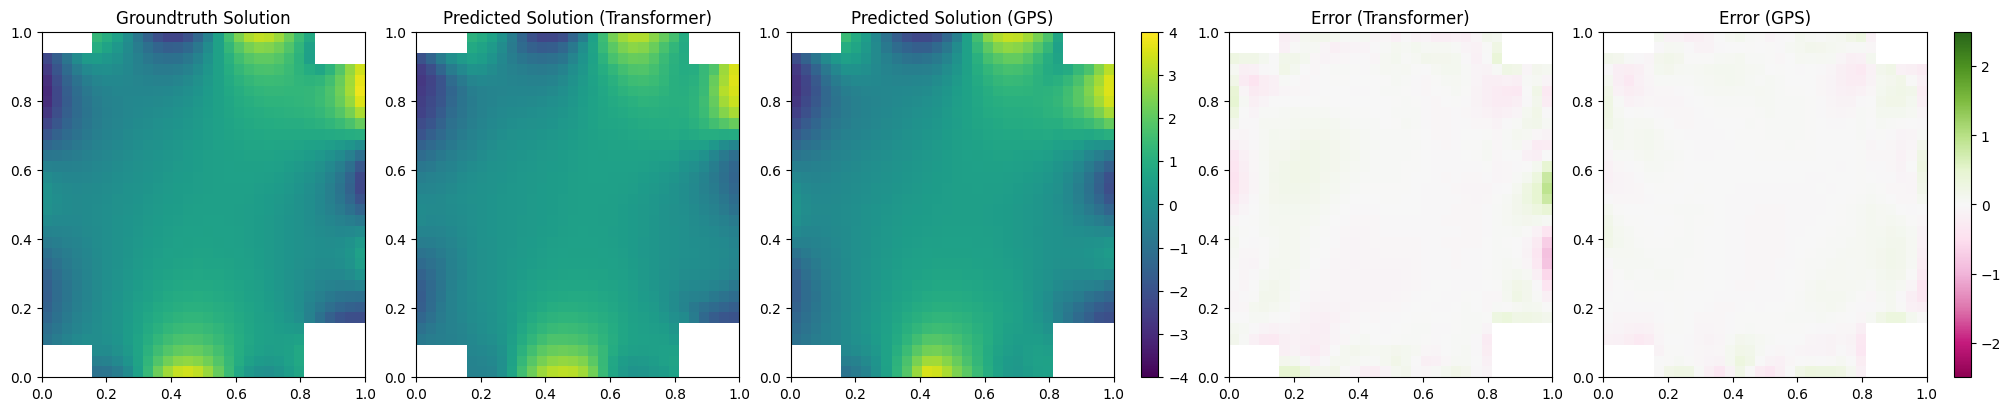

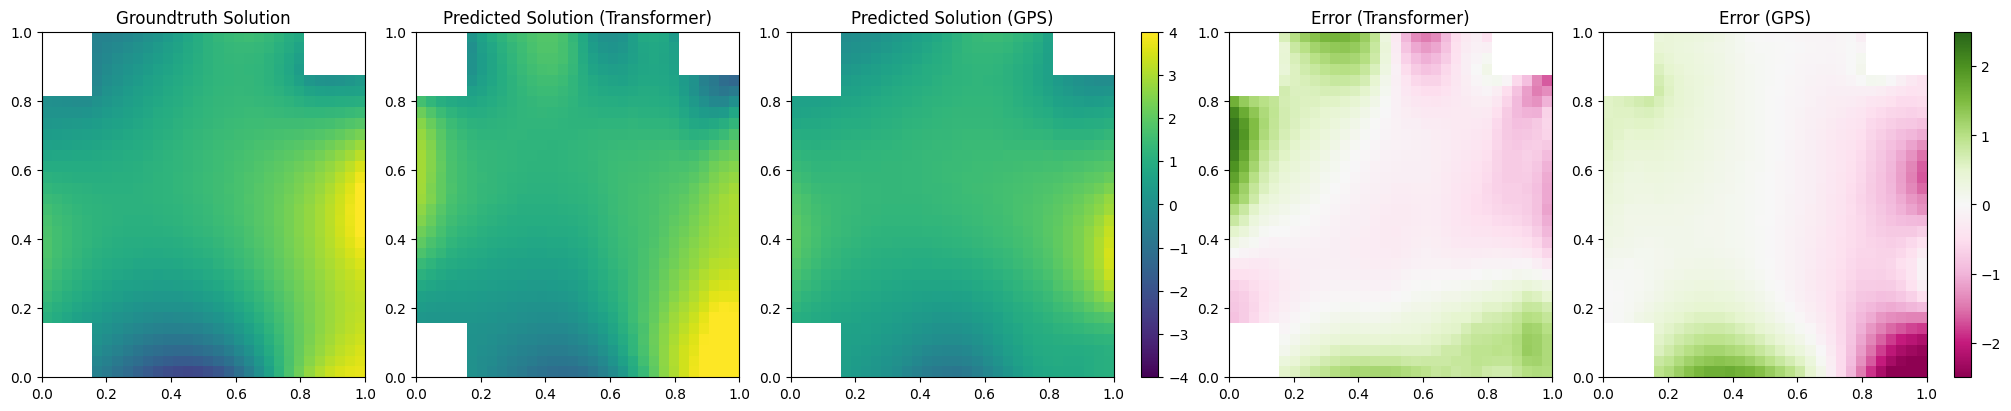

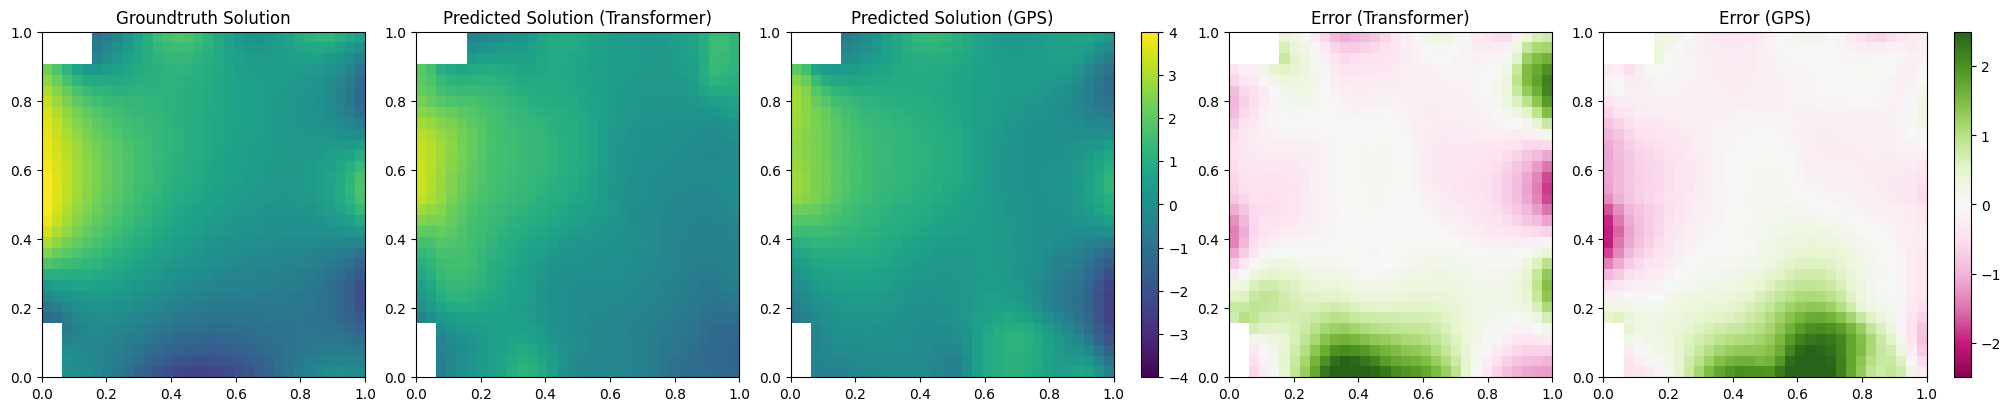

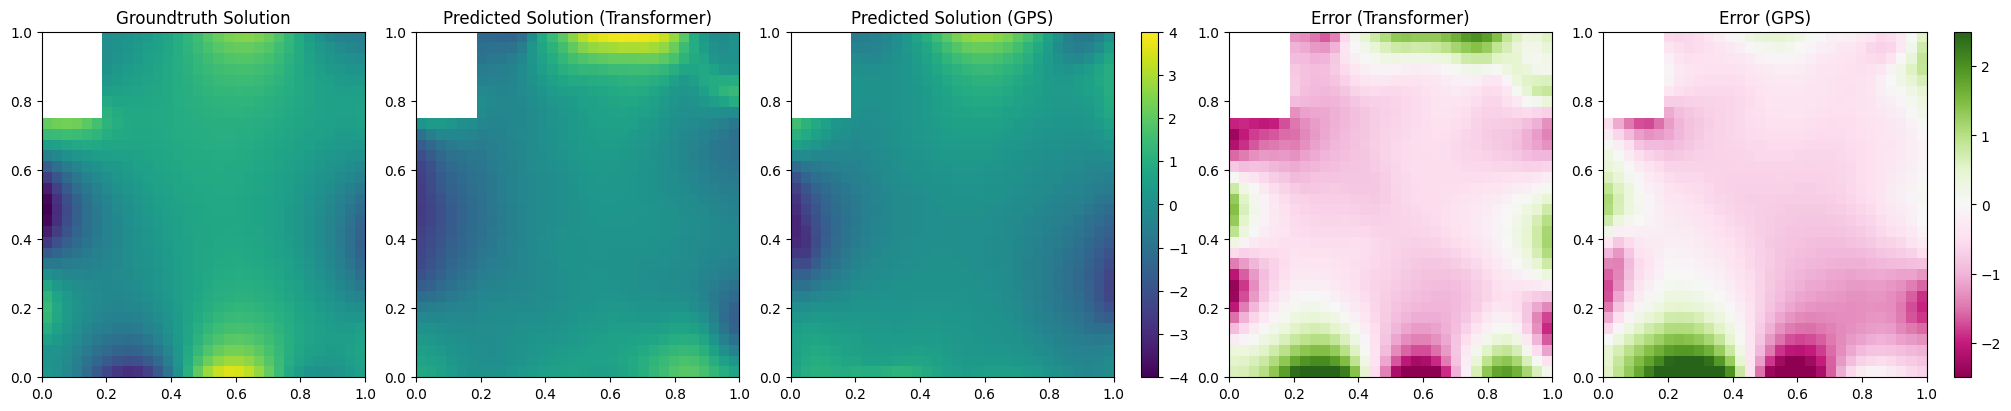

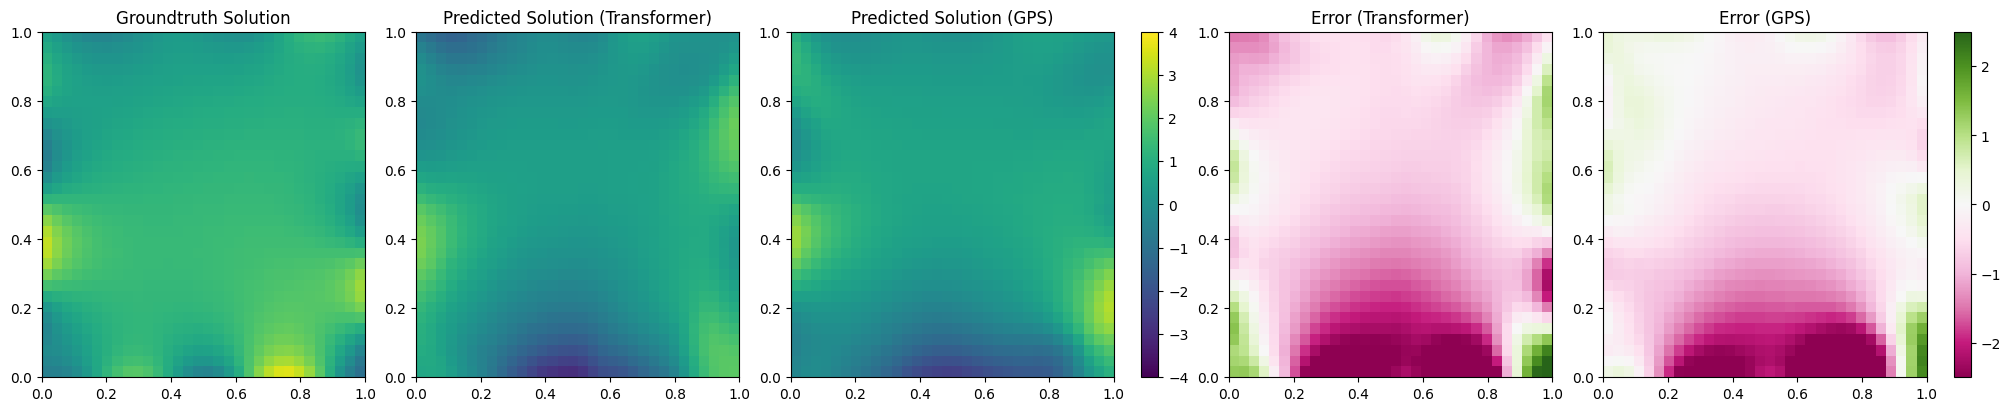

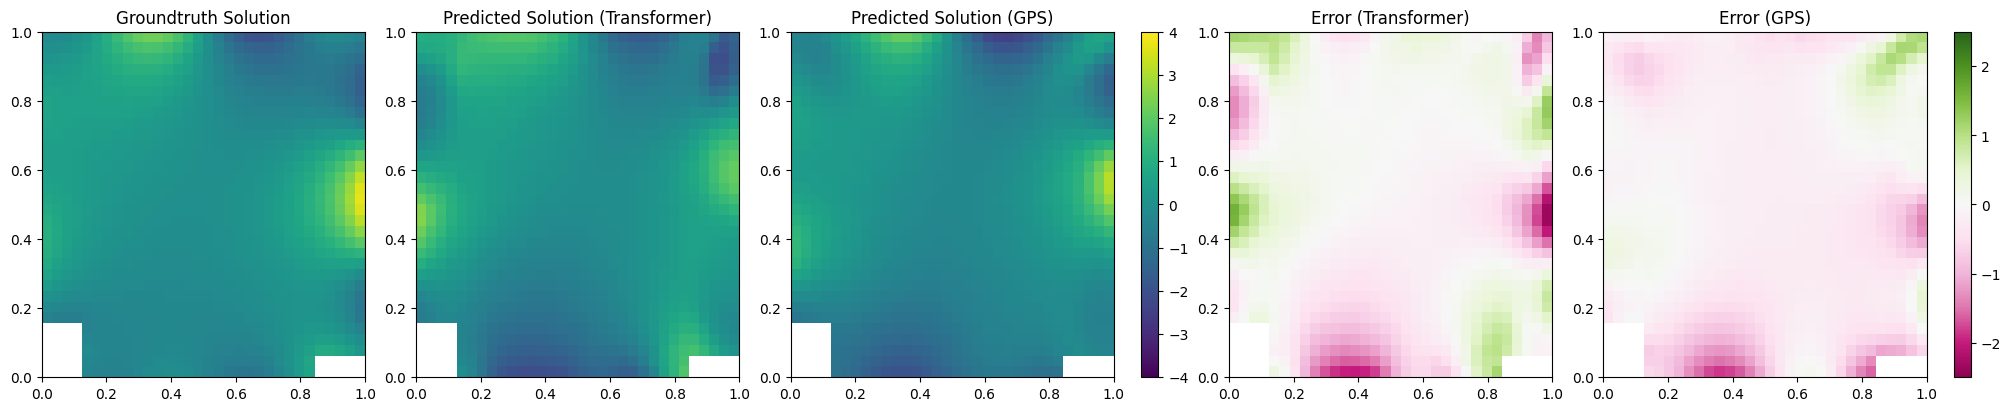

In [85]:
coord_all = coord_alls[args.bd_shape]
for shape in shapes:
    data_train = datasets_train[shape]
    coord_all = coord_alls[shape]
    plot_prediction(data_train, coord_all, 79,args)

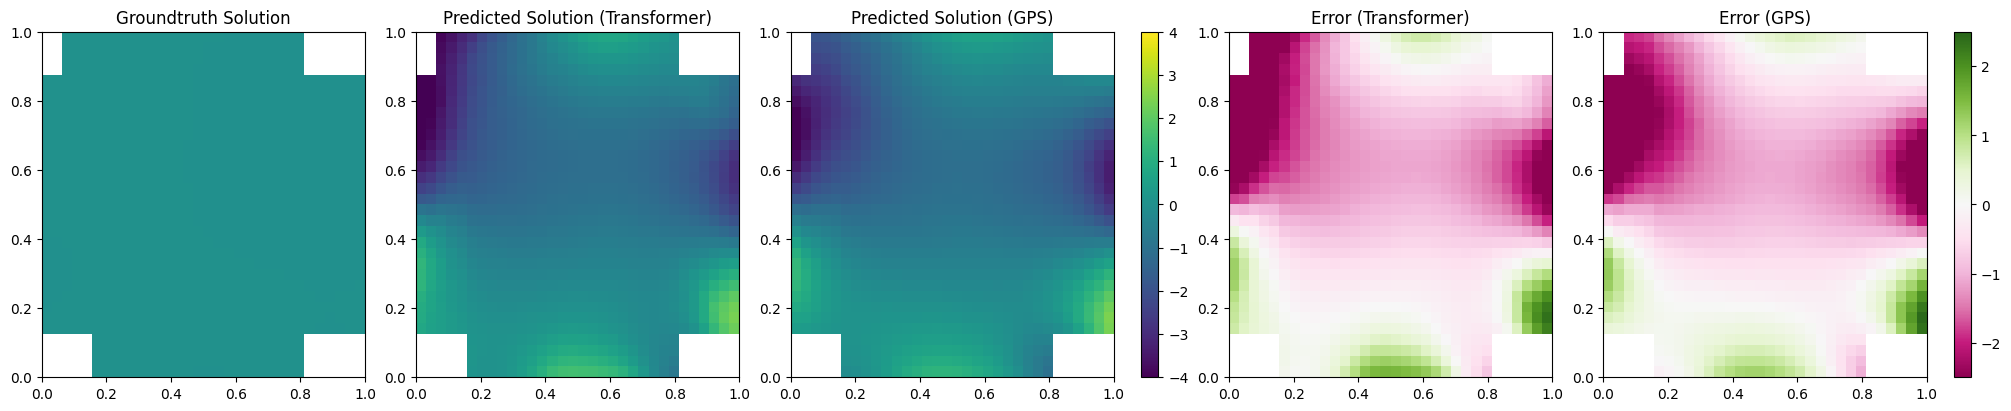

In [92]:
data_test = datasets_test[args.bd_shape]
plot_prediction(data_test, coord_all, 0,args)

In [71]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [74]:
torch.cuda.empty_cache()


In [93]:
from google.colab import files
files.download('/content/beno/results/Resolution_32_poisson_ntrain90_kerwidth256_bd_enc_GPS3_Rollingregular_shape4c_ns100_nheads4_bddim128_actsilulr5e-05_nmlp_layers3_epochs1000')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>